In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.model_selection as ms
import sklearn.metrics as sklm
from sklearn import preprocessing
from xgboost import XGBRegressor

import numpy.random as nr
import scipy.stats as ss
import math
#import missingno as mn           # For visualizing missing values.
from scipy import stats          # For statistics

%matplotlib inline

In [76]:
data_train = pd.read_csv('TrainFeatures4TreesNew1.csv')
data_test = pd.read_csv('TestFeatures4TreesNew1.csv')
Labels = pd.read_csv('TrainLabelPow.csv')

merged = pd.concat([data_train,data_test])
#merged = pd.concat([train, test], sort = False)

In [77]:
num_cols = ['Product_Price', 'Product_Shelf_Visibility', 'Supermarket_Opening_Year', 'Product_Price_Pow', 
            'Product_Shelf_Visibility_Pow', 'Type_Sales_Ave_SMT', 'Type_Sales_Min_SMT', 'Type_Sales_Max_SMT', 
            'Type_Sales_Ave_SMLT', 'Type_Sales_Min_SMLT', 'Type_Sales_Max_SMLT', 'Price_Binned_Num', 
            'Product_Price_Log', 'Product_Shelf_Visibility_Exp']
cat_cols = [col for col in data_test.columns if col not in num_cols]

list(data_test.columns) == list(merged.columns)

True

In [78]:
def encode_string(cat_feature):
    ## First encode the strings to numeric categories
    enc = preprocessing.LabelEncoder()
    enc.fit(cat_feature)
    enc_cat_feature = enc.transform(cat_feature)
    ## Now, apply one hot encoding
    ohe = preprocessing.OneHotEncoder()
    encoded = ohe.fit(enc_cat_feature.reshape(-1,1))
    return encoded.transform(enc_cat_feature.reshape(-1,1)).toarray()


In [79]:
Features = encode_string(merged[cat_cols[0]])
for col in cat_cols:
    if col != cat_cols[0]:
        temp = encode_string(merged[col])
        Features = np.concatenate([Features, temp], axis = 1)

print(Features.shape)
print(Features[:2, :])  

(8522, 53)
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.
   0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.
   0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.
   0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.
   0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]]


In [80]:
Features = np.concatenate([Features, np.array(merged[num_cols])], axis = 1)
Features[:2,:]
print(Features.shape)

(8522, 67)


In [81]:
scaler = preprocessing.StandardScaler().fit(Features[:,53:])
Features[:,53:] = scaler.transform(Features[:,53:])

print(Features.shape)
Features[:1,:]

(8522, 67)


array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.032555  ,  0.04652692,
         0.02008574,  0.14890382,  0.26170106, -1.91443123, -0.67418707,
        -2.3048262 , -0.32598256, -0.99857463,  1.16305858,  0.51907251,
         0.25626095,  0.01959036]])

In [82]:
'''Set a seed for reproducibility'''
seed = 43

"""Let's split the train and test set to feed machine learning algorithm."""
df_train = np.array(pd.DataFrame(Features).iloc[:4990, :])
df_test  = np.array(pd.DataFrame(Features).iloc[4990:, :])


In [83]:
## Randomly sample cases to create independent training and test data
nr.seed(9988)
Labels = np.array(Labels)
indx = range(df_train.shape[0])
indx = ms.train_test_split(indx, test_size = 0.4)
x_train = df_train[indx[0],:]
y_train = np.ravel(Labels[indx[0]])
x_test = df_train[indx[1],:]
y_test = np.ravel(Labels[indx[1]])

In [84]:
xgbReg = XGBRegressor()

In [85]:
xgbReg.fit(x_train,y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(xgbReg, random_state=1).fit(x_test, y_test)
eli5.show_weights(perm, feature_names = x_test.columns.tolist())

In [36]:
## define and fit the linear regression model

def print_metrics(y_true, y_predicted):
    ## First compute R^2 and the adjusted R^2
    r2 = sklm.r2_score(y_true, y_predicted)
    
    ## Print the usual metrics and the R^2 values
    print('Mean Square Error      = ' + str(sklm.mean_squared_error(y_true, y_predicted)))
    print('Root Mean Square Error = ' + str(math.sqrt(sklm.mean_squared_error(y_true, y_predicted))))
    print('Mean Absolute Error    = ' + str(sklm.mean_absolute_error(y_true, y_predicted)))
    print('Median Absolute Error  = ' + str(sklm.median_absolute_error(y_true, y_predicted)))
    print('R^2                    = ' + str(r2))
    
def resid_plot(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.regplot(y_score, resids, fit_reg=False)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')
    plt.show()

def hist_resids(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.distplot(resids)
    plt.title('Histogram of residuals')
    plt.xlabel('Residual value')
    plt.ylabel('count')
    plt.show()
    
def resid_qq(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test, y_score)
    ## now make the residual plots
    ss.probplot(resids.flatten(), plot = plt)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')
    plt.show()

Mean Square Error      = 288.943752987
Root Mean Square Error = 16.99834559558392
Mean Absolute Error    = 13.3093040559
Median Absolute Error  = 10.7894036189
R^2                    = 0.663097551365


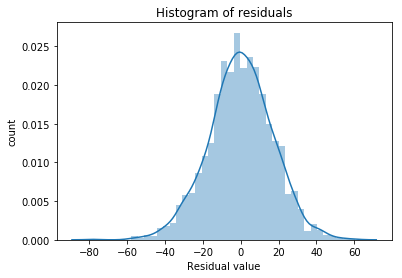

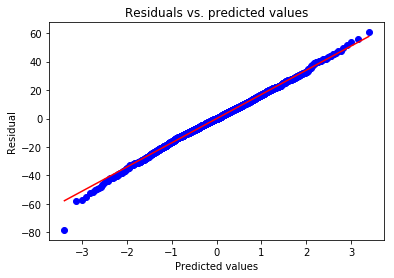

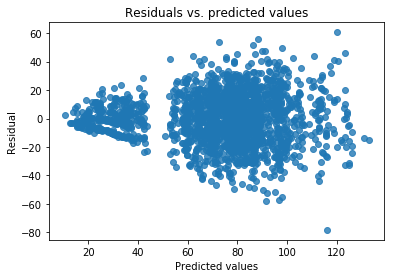

In [86]:
predictions = xgbReg.predict(x_test)
print_metrics(y_test, predictions) 
hist_resids(y_test, predictions)  
resid_qq(y_test, predictions) 
resid_plot(y_test, predictions) 

In [87]:
test_predictions = xgbReg.predict(df_test)

In [88]:
sub = pd.read_csv('submXGB2.csv')

In [64]:
sub.head()

,Product_Supermarket_Identifier,Product_Supermarket_Sales
0,DRA59_CHUKWUDI010,1699.447998
1,DRA59_CHUKWUDI013,7578.218262
2,DRB01_CHUKWUDI013,7552.823730
3,DRB13_CHUKWUDI010,1705.011230
4,DRB13_CHUKWUDI013,7603.656250


In [89]:
sub['Product_Supermarket_Sales'] = pow(test_predictions,2)

In [90]:
sub.describe()

,Product_Supermarket_Sales
count,3532.000000
mean,4331.082520
std,2892.914551
min,108.892799
25%,1903.687683
50%,3352.035645
75%,6910.426514
max,17361.697266


In [91]:
sub.to_csv('submXGBPow.csv', index=False)

In [92]:
xgb2 = XGBRegressor()

In [93]:
xgb2.fit(df_train,np.ravel(Labels))

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [94]:
test_predictions2 = xgb2.predict(df_test)
sub['Product_Supermarket_Sales'] = pow(test_predictions2,2)

In [95]:
sub.to_csv('submXGBPowALL.csv', index=False)
sub.head()

,Product_Supermarket_Identifier,Product_Supermarket_Sales
0,DRA59_CHUKWUDI010,1106.137451
1,DRA59_CHUKWUDI013,7706.955566
2,DRB01_CHUKWUDI013,7636.208008
3,DRB13_CHUKWUDI010,1113.183838
4,DRB13_CHUKWUDI013,7441.465820


In [96]:
sub.describe()

,Product_Supermarket_Sales
count,3532.000000
mean,4260.933105
std,2819.033691
min,161.514313
25%,1971.434937
50%,3301.575439
75%,6778.714355
max,16338.740234


# Cross Validation

In [59]:
print(xgbReg)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)


In [25]:
learning_rate = [0.3]
n_estimators = [50, 100, 150, 200,400]
max_depth = [2, 3, 4, 5, 6, 7, 8]
min_child_weight = [3,4,5,6]

In [26]:
param_grid = dict(learning_rate=learning_rate)

In [27]:
xgb_cv = XGBRegressor()
kfold = ms.KFold(n_splits=10, shuffle=True, random_state=144)

grid_search = ms.GridSearchCV(estimator = xgb_cv, param_grid = param_grid,
                              cv = kfold, scoring = "neg_mean_squared_error",
                              return_train_score = True)

In [ ]:
## Fit thhe cross validated grid search over the data 
grid_search.fit(df_train, labels)

## Compute principle components

The code in the cell below computes the principle components for the training feature subset. Execute this code:

In [12]:
pca_mod = skde.PCA()
pca_comps = pca_mod.fit(x_train)
pca_comps

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [13]:
print(pca_comps.explained_variance_ratio_)
print(np.sum(pca_comps.explained_variance_ratio_))

[  1.48972645e-01   8.79756980e-02   7.66858789e-02 ...,   2.77596302e-05
   2.77596302e-05   7.53560265e-29]
1.0


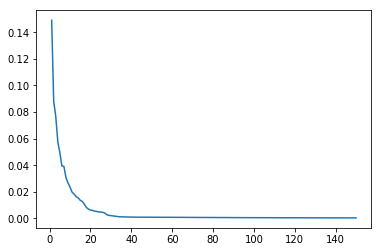

In [23]:
def plot_explained(mod):
    comps = mod.explained_variance_ratio_[:150]
    x = range(len(comps))
    x = [y + 1 for y in x]          
    plt.plot(x,comps)

plot_explained(pca_comps)

** Select the best 25 features **

In [155]:
pca_mod_25 = skde.PCA(n_components = 50)
pca_mod_25.fit(x_train)
Comps = pca_mod_25.transform(x_train)
Comps.shape

(2994, 50)

## Compute and evaluate a xgboost regression model

In [212]:
## Define and fit the logistic regression model
xgb25 = XGBRegressor(max_depth=2,n_estimators=372,learning_rate=0.05) 
xgb25.fit(Comps, y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=372, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [213]:
xgb_new = XGBRegressor(max_depth=3,n_estimators=372,learning_rate=0.05) 
xgb_new.fit(x_train,y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=372, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [214]:
xgb_new_pred = xgb_new.predict(x_test)

Mean Square Error      = 8242974.7621
Root Mean Square Error = 2871.0581258663997
Mean Absolute Error    = 2100.43782375
Median Absolute Error  = 1554.1745874
R^2                    = 0.565805328632


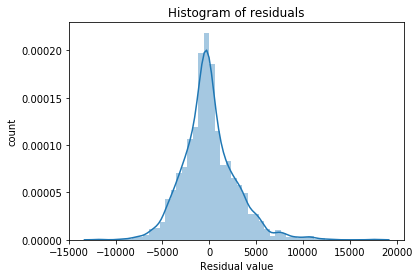

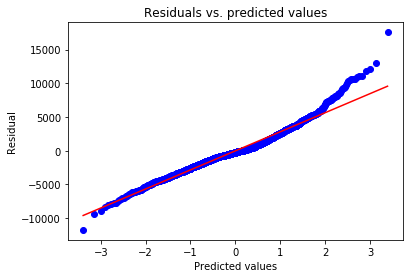

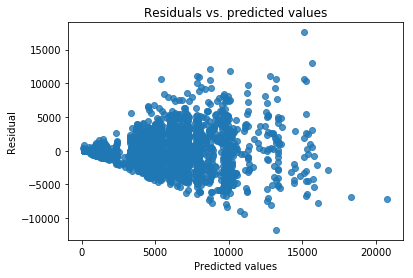

In [215]:
print_metrics(y_test, xgb_new_pred) 
hist_resids(y_test, xgb_new_pred)  
resid_qq(y_test, xgb_new_pred) 
resid_plot(y_test, xgb_new_pred) 

In [207]:
pred25 = xgb25.predict(pca_mod_25.transform(x_test))

In [208]:
print_metrics(y_test, pred25) 
#hist_resids(y_test, pred25)  
#resid_qq(y_test, pred25) 
#resid_plot(y_test, pred25) 

Mean Square Error      = 8639082.9909
Root Mean Square Error = 2939.231700784376
Mean Absolute Error    = 2150.19963965
Median Absolute Error  = 1611.2922168
R^2                    = 0.544940521061
